# Проект: Статистический анализ данных
## Cервис аренды самокатов

#### Введение

В современном мире городской мобильности сервисы аренды самокатов становятся все более популярными.
Компания, предоставляющая услуги аренды самокатов, стремится улучшить свой бизнес и расширить клиентскую базу.

Для достижения этих целей необходим тщательный анализ данных о пользователях и их поездках.

Основная цель данного исследования — проанализировать предоставленные данные о пользователях, их поездках и подписках, чтобы выявить закономерности, которые могут помочь в определении точек роста.

Особое внимание будет уделено сравнению поведения пользователей с подпиской и без, а также оценке влияния различных факторов на выручку компании, кроме того в ходе исследования будут проверены гипотезы которые должны помочь отделу маркетинга.

#### План работы
1. Импорты библиотек и загрузка датафреймов
2. Знакомство с данными
3. Предобработка данных
4. Исследовательский анализ
5. Объединение данных
6. Подсчет выручки
7. Проверка гипотез
8. Формулирование выводов и рекомендаций

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

#### Загрузка данных

In [3]:
data_sources = {
    'users_data': 'users_go.csv',
    'rides_data': 'rides_go.csv',
    'subscriptions_data': 'subscriptions_go.csv'
}

base_url = 'https://code.s3.yandex.net/datasets/'

datasets = {}

for name, file in data_sources.items():
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        df = pd.read_csv(base_url + file)
    datasets[name] = df

users_data = datasets['users_data']
rides_data = datasets['rides_data']
subscriptions_data = datasets['subscriptions_data']

In [4]:
def analyze_dataframes(datasets, *operations, separator='-' * 80):
    """
    Анализирует датафреймы, выполняя указанные операции.
    :param datasets: Словарь с датафреймами
    :param operations: Lambda-функции для выполнения над датафреймами
    :param separator: Строка-разделитель для вывода
    """
    for name, df in datasets.items():
        print(f'DataFrame `{name}`')
        for op in operations:
            result = op(df)
            if result is not None:
                print(result)
        print(separator)

In [5]:
FIGSIZE = (10, 6)

##### Описание данных
###### users_go.csv

1. user_id - уникальный идентификатор пользователя
2. name	- имя пользователя
3. age - возраст
4. city - город
5. subscription_type - тип подписки (free, ultra)

###### rides_go.csv

1. user_id - уникальный идентификатор пользователя
2. distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
3. duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
4. date	дата - совершения поездки

###### subscriptions_go.csv

1. subscription_type - тип подписки
2. minute_price - стоимость одной минуты поездки по данной подписке
3. start_ride_price - стоимость начала поездки
4. subscription_fee - стоимость ежемесячного платежа

##### Знакомство с данными

In [6]:
analyze_dataframes(datasets, lambda df: df.head())

DataFrame `users_data`
   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
--------------------------------------------------------------------------------
DataFrame `rides_data`
   user_id  distance  duration        date
0        1  4,409.92     25.60  2021-01-01
1        1  2,617.59     15.82  2021-01-18
2        1    754.16      6.23  2021-04-20
3        1  2,694.78     18.51  2021-08-11
4        1  4,028.69     26.27  2021-08-28
--------------------------------------------------------------------------------
DataFrame `subscriptions_data`
  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50          

In [7]:
analyze_dataframes(datasets, lambda df: df.info())

DataFrame `users_data`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
--------------------------------------------------------------------------------
DataFrame `rides_data`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memor

In [8]:
analyze_dataframes(datasets, lambda df: df.describe())

DataFrame `users_data`
       user_id      age
count 1,565.00 1,565.00
mean    762.63    24.92
std     443.26     4.55
min       1.00    12.00
25%     378.00    22.00
50%     762.00    25.00
75%   1,146.00    28.00
max   1,534.00    43.00
--------------------------------------------------------------------------------
DataFrame `rides_data`
        user_id  distance  duration
count 18,068.00 18,068.00 18,068.00
mean     842.87  3,070.66     17.81
std      434.73  1,116.83      6.09
min        1.00      0.86      0.50
25%      487.00  2,543.23     13.60
50%      889.00  3,133.61     17.68
75%    1,213.25  3,776.22     21.72
max    1,534.00  7,211.01     40.82
--------------------------------------------------------------------------------
DataFrame `subscriptions_data`
       minute_price  start_ride_price  subscription_fee
count          2.00              2.00              2.00
mean           7.00             25.00             99.50
std            1.41             35.36            140.

In [9]:
sub_type = users_data.groupby('subscription_type').count()['user_id']
print(sub_type)

subscription_type
free     846
ultra    719
Name: user_id, dtype: int64


In [10]:
difference = ((sub_type['free'] - sub_type['ultra']) / sub_type['ultra']) * 100
print(f"Пользователей с бесплатной подпиской больше на {difference:.2f}%")

Пользователей с бесплатной подпиской больше на 17.66%


#### Выводы
1. О пользователях `users_data`:
    * Всего 1565 пользователей.
    * Пропущенных данных о пользователях нет.
    * Возраст пользователей варьируется от 12 до 43 лет, со средним 24 и медианным 25 лет.
    * Пользователей с бесплатной подпиской 846, их на 127 больше, что составляет 17.66%, чем пользователей с платной подпиской 719.
2. О поездках `rides_data`:
    * Всего 18068 записей о поездках.
    * Пропущенных данных нет.
    * Средняя дистанция поездки 3070, медианная 3133, максимальная 7211 метров.
    * Минимальная дистанция поездки менее 1 метра, это может указывать на ошибки, как технические, так и например говорить о ситуации `пользователь случайно начал поездку` вероятно это нужно `проанализировать дополнительно`.
    * Средняя и медианная продолжительность поездки ~17 минут, максимальная продолжительность 40 минут.
    * Минимальная продолжительность поездки менее 1 минуты, возможно `это те самые короткие поездки`.
    * `Дату нужно превести к формату даты` столбец `date`.
    * Считаю что `расстояние и продолжительность` нужно привести к `целочисленному типу`.
3. О подписках `subscriptions_data`:
    * Существует два варианта использования самоката, с подпиской и без подписки.
        1. без подписки - `free`:
            - абонентская плата отсутствует.
            - стоимость одной минуты поездки — 8 рублей.
            - стоимость старта (начала поездки) — 50 рублей.
        2. с подпиской `ultra`:
            - абонентская плата — 199 рублей в месяц.
            - стоимость одной минуты поездки — 6 рублей.
            - стоимость старта — бесплатно.

    

#### Предобработка данных
##### Преобразование даты в дату

In [11]:
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d') # 2021-01-01

##### Преобразование `distance` и `duration` в `integer`

In [12]:
columns = ('distance', 'duration')

for col in columns:
    #rides_data[col] = rides_data[col].astype(int)
    rides_data[col] = np.ceil(rides_data[col])

In [13]:
rides_data.head()

,user_id,distance,duration,date
0,1,"4,410.00",26.00,2021-01-01
1,1,"2,618.00",16.00,2021-01-18
2,1,755.00,7.00,2021-04-20
3,1,"2,695.00",19.00,2021-08-11
4,1,"4,029.00",27.00,2021-08-28


In [14]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Пропуски

In [15]:
analyze_dataframes(datasets, lambda df: df.isna().sum())

DataFrame `users_data`
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
--------------------------------------------------------------------------------
DataFrame `rides_data`
user_id     0
distance    0
duration    0
date        0
dtype: int64
--------------------------------------------------------------------------------
DataFrame `subscriptions_data`
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
--------------------------------------------------------------------------------


##### Дубликаты

In [16]:
analyze_dataframes(datasets, lambda df: df.duplicated().sum())

DataFrame `users_data`
31
--------------------------------------------------------------------------------
DataFrame `rides_data`
0
--------------------------------------------------------------------------------
DataFrame `subscriptions_data`
0
--------------------------------------------------------------------------------


In [17]:
users_data['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [18]:
users_data['name'] = users_data['name'].str.strip()
users_data['name'] = users_data['name'].str.capitalize()

In [19]:
duplicateRows = users_data[users_data.duplicated(keep=False)]
duplicateRows.sort_values(by=['user_id'])

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1539,43,Стефания,22,Омск,ultra
42,43,Стефания,22,Омск,ultra
46,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1244,1245,Регина,27,Пятигорск,free


In [20]:
users_data_len_before_drop = len(users_data)
users_data = users_data.drop_duplicates()
a, b = users_data_len_before_drop, len(users_data)
print(a, b, round((a-b)/a*100, 2), '% данных удалено.')

1565 1534 1.98 % данных удалено.


##### Новый столбец с номером месяца на основе столбца `date`.

In [21]:
rides_data['month'] = rides_data['date'].dt.month

In [22]:
rides_data.head(10)

,user_id,distance,duration,date,month
0,1,"4,410.00",26.00,2021-01-01,1
1,1,"2,618.00",16.00,2021-01-18,1
2,1,755.00,7.00,2021-04-20,4
3,1,"2,695.00",19.00,2021-08-11,8
4,1,"4,029.00",27.00,2021-08-28,8
5,1,"2,771.00",17.00,2021-10-09,10
6,1,"3,040.00",15.00,2021-10-19,10
7,1,"2,843.00",24.00,2021-11-06,11
8,1,"3,413.00",16.00,2021-11-14,11
9,1,749.00,16.00,2021-11-22,11


#### Выводы
1. Согласно заданию добавлен столбец `month` на основе столбца `date`
2. В `users_data` найдены и удалены явные дубликаты.
3. В `rides_data` и `subscriptions_data` дубликаты отсутствуют.
4. Пропуски отсутствуют во всех предоставленных DataFrame.

#### Исследовательский анализ данных

##### Частота встречаемости городов

In [23]:
city_counts = users_data['city'].value_counts()
city_counts

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

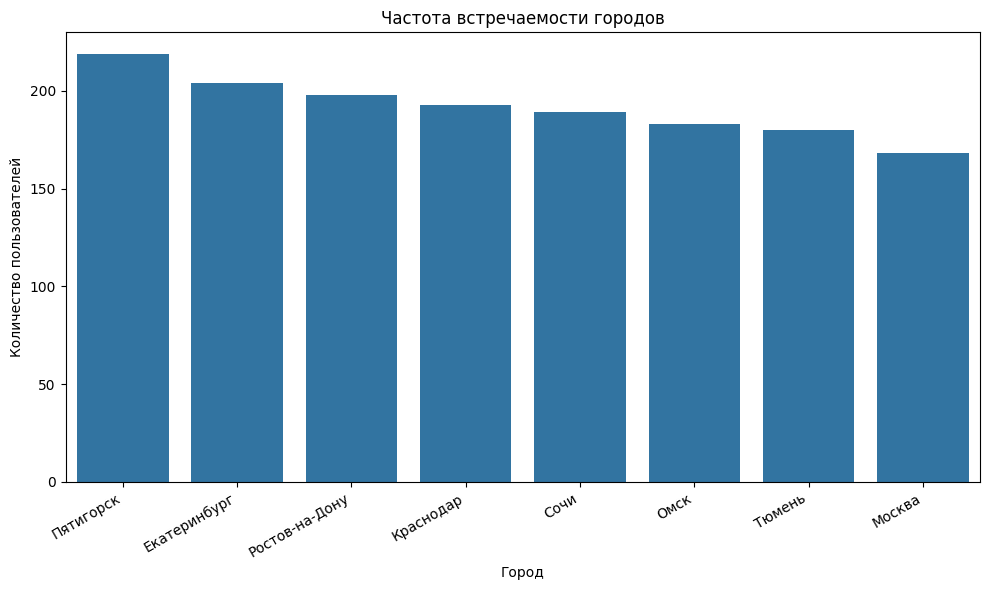

In [24]:
plt.figure(figsize=FIGSIZE)
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

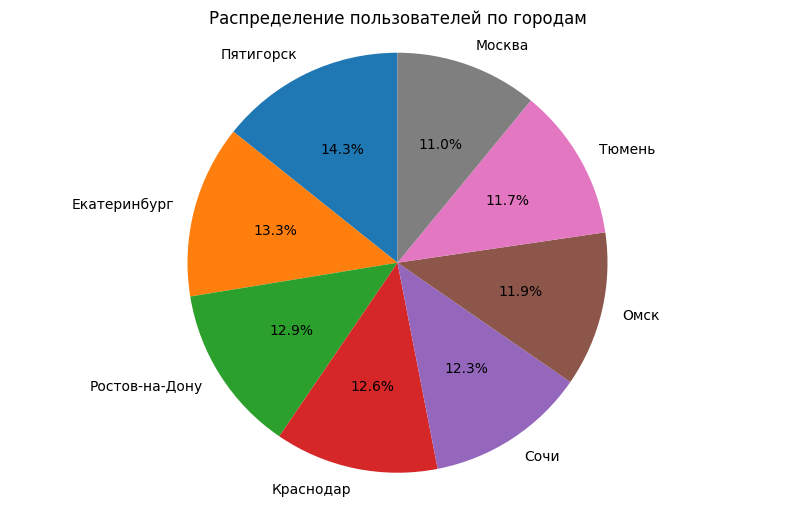

In [25]:
plt.figure(figsize=FIGSIZE)
plt.pie(city_counts.values, labels=city_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение пользователей по городам')
plt.axis('equal')
plt.show()

In [26]:
subscription_counts = users_data['subscription_type'].value_counts()
subscription_counts

subscription_type
free     835
ultra    699
Name: count, dtype: int64

###### Вывод
`Равномерность распределения`: Несмотря на наличие лидеров и отстающих, разница между максимальной и минимальной долями не очень велика (14.3% vs 11.0%), что говорит о относительно равномерном распределении пользователей по городам.

##### Cоотношение пользователей с подпиской и без подписки

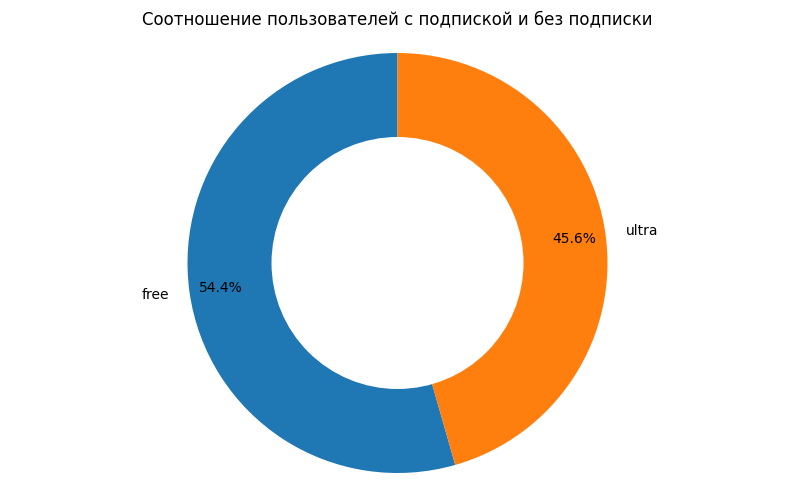

In [27]:

plt.figure(figsize=FIGSIZE)
plt.pie(subscription_counts.values, labels=subscription_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.axis('equal')
plt.show()

###### Вывод
Сервис демонстрирует хороший баланс между бесплатными и платными пользователями, что указывает на эффективную бизнес-модель. Однако есть потенциал для увеличения доли пользователей с подпиской.

##### Возраст пользователей

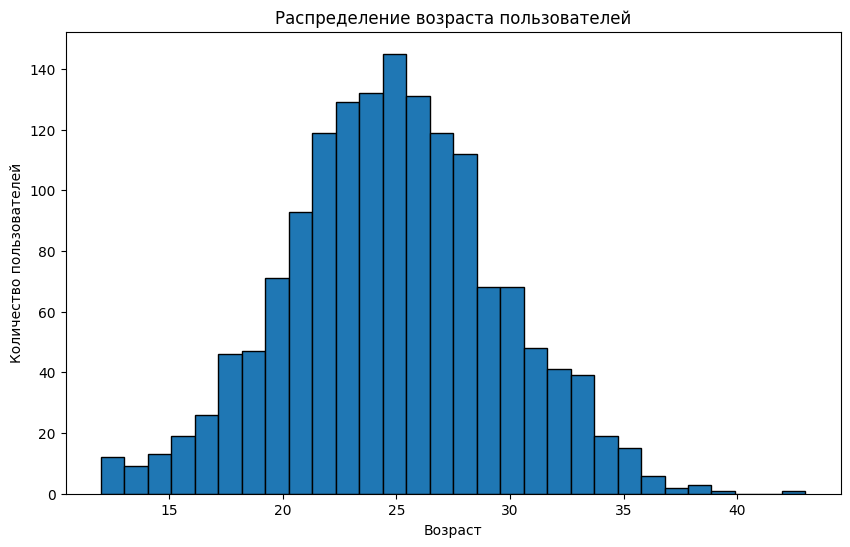

In [28]:
plt.figure(figsize=FIGSIZE)
plt.hist(users_data['age'], bins=30, edgecolor='black')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

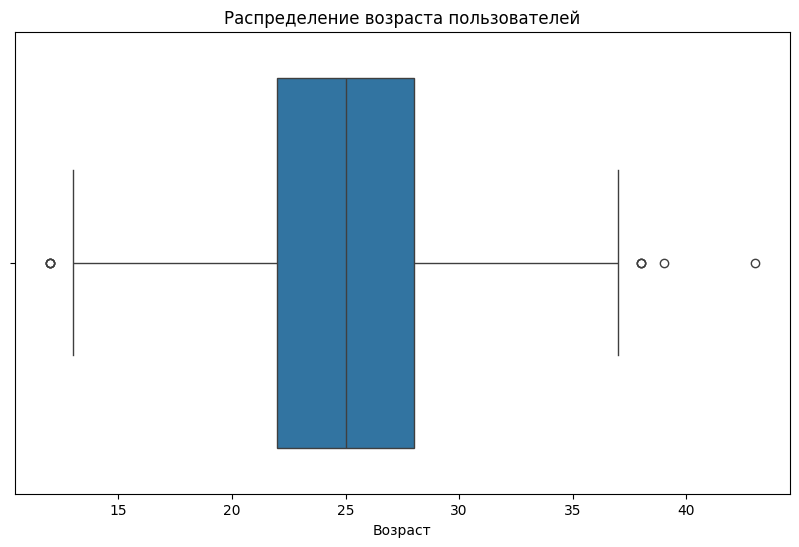

In [29]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(x=users_data['age'])
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.show()

###### Наблюдаются выбросы!

In [30]:
users_data.sort_values(by='age').head()

,user_id,name,age,city,subscription_type
66,67,Анастасия,12,Ростов-на-Дону,ultra
664,665,Герман,12,Сочи,ultra
727,728,Вячеслав,12,Пятигорск,free
34,35,Руслан,12,Пятигорск,ultra
1241,1242,Майя,13,Омск,free


In [31]:
users_data.sort_values(by='age', ascending=False).head()

,user_id,name,age,city,subscription_type
1201,1202,Ангелина,43,Москва,free
961,962,Дмитрий,39,Москва,free
453,454,Вероника,38,Краснодар,ultra
804,805,Петр,38,Тюмень,free
383,384,Виктор,38,Омск,ultra


###### ПДД!
Стоит обратить внимание что по согласно ПДД до 14 лет на электросамокате можно перемещаться только в пешеходных зонах и в `велосипедной` части велодорожек, при этом по проезжей части на электросамокате можно передвигаться только с 14 лет.

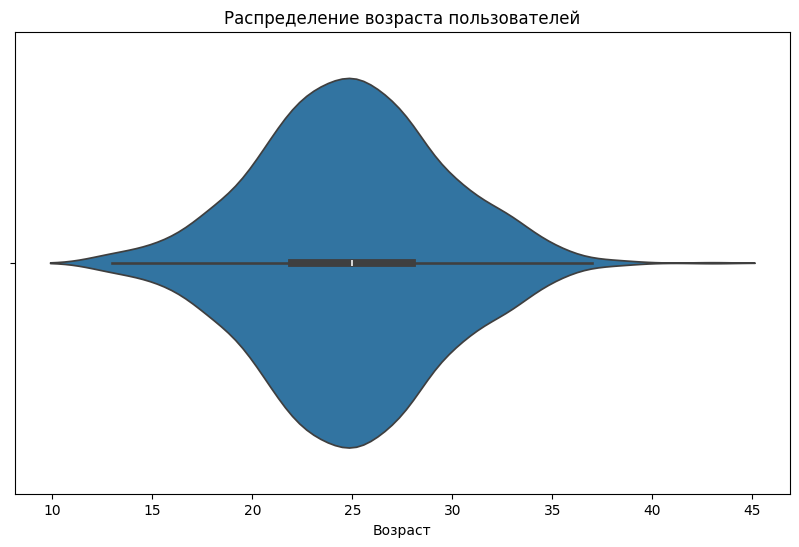

In [32]:
plt.figure(figsize=FIGSIZE)
sns.violinplot(x=users_data['age'])
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.show()

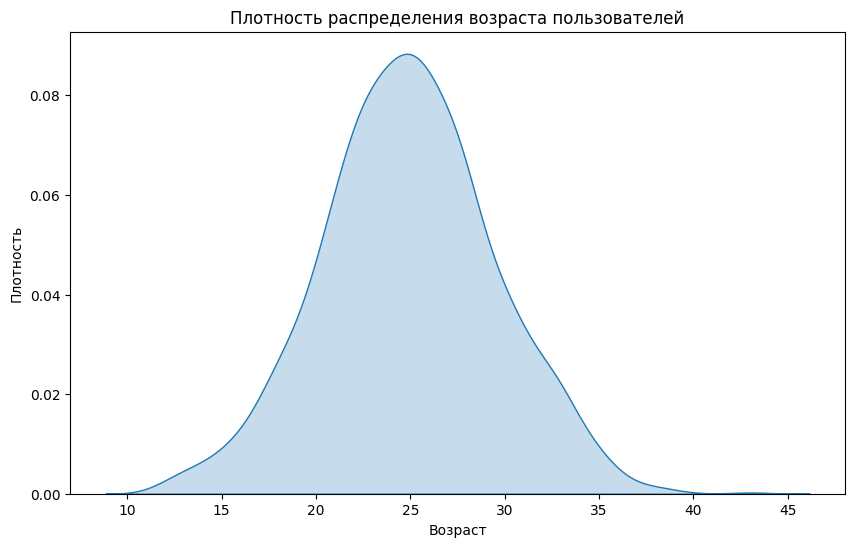

In [33]:
plt.figure(figsize=FIGSIZE)
sns.kdeplot(data=users_data['age'], fill=True)
plt.title('Плотность распределения возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.show()

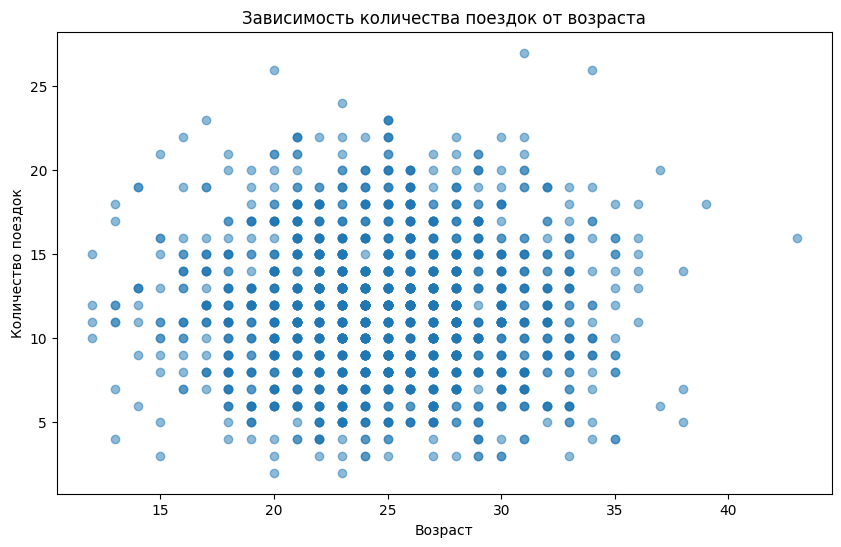

In [34]:
rides_count = rides_data.groupby('user_id').size().reset_index(name='rides_count')
merged_data = users_data.merge(rides_count, on='user_id')

plt.figure(figsize=FIGSIZE)
plt.scatter(merged_data['age'], merged_data['rides_count'], alpha=0.5)
plt.title('Зависимость количества поездок от возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество поездок')
plt.show()

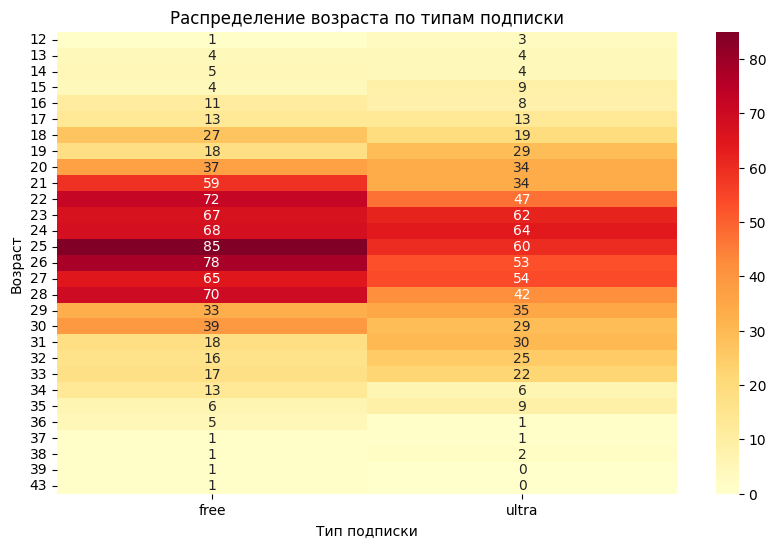

In [35]:
age_subscription = pd.crosstab(users_data['age'], users_data['subscription_type'])

plt.figure(figsize=FIGSIZE)
sns.heatmap(age_subscription, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Распределение возраста по типам подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Возраст')
plt.show()

###### Выводы
* `Общее распределение`: Распределение расстояний имеет ярко выраженную колоколообразную форму с небольшой правосторонней асимметрией, распределение имеет относительно узкий пик, что говорит о концентрации целевой аудитории
* `Межквартильный размах`: примерно от 22 до 30 лет
* `Наибольшая плотность пользователей`: наблюдается в возрасте 23-28 лет
* `Отсутствие корреляции`: нет явной линейной зависимости между возрастом и количеством поездок.
* `Наибольшая активность`: наблюдается у пользователей в возрасте 20-35 лет
* `Платная подписка` имеет равномерное распределение по возрастам. Пользователи 20 - 30 лет чаще выбирают платную подписку.


##### Расстояние за одну поездку

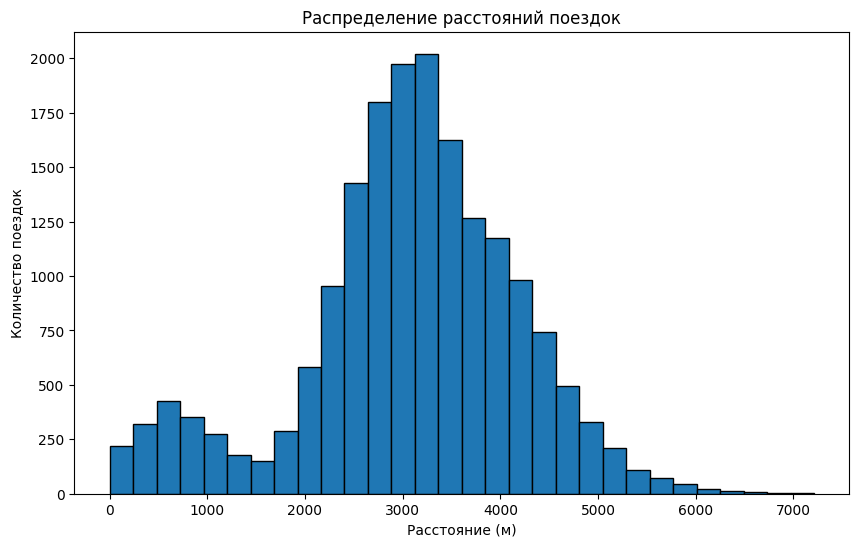

In [36]:
plt.figure(figsize=FIGSIZE)
plt.hist(rides_data['distance'], bins=30, edgecolor='black')
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.show()

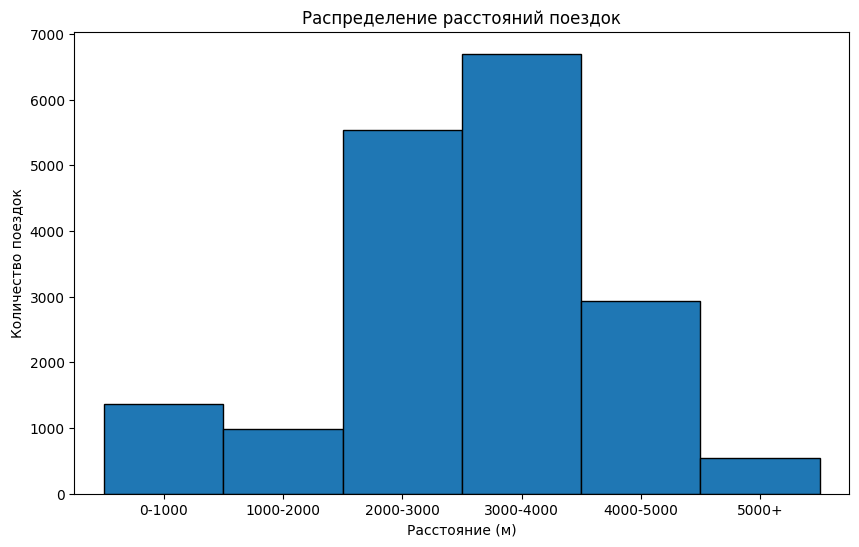

In [37]:
distance_bins = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000+']

rides_data['distance_group'] = pd.cut(rides_data['distance'], bins=distance_bins, labels=labels, include_lowest=True)

distance_distribution = rides_data['distance_group'].value_counts().sort_index()

plt.figure(figsize=FIGSIZE)
distance_distribution.plot(kind='bar', width=1, edgecolor='black')
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.xticks(rotation=0)
plt.show()

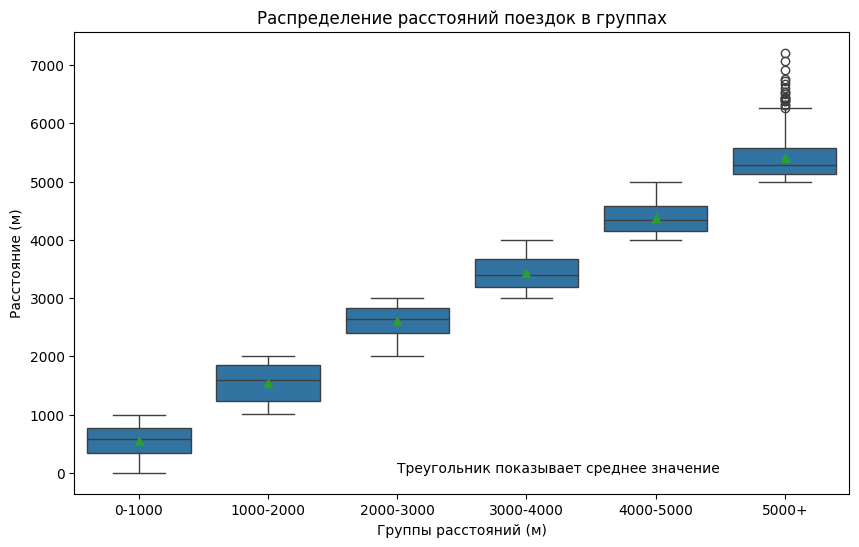

In [38]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(x='distance_group', y='distance', data=rides_data, order=labels, showmeans=True)
plt.title('Распределение расстояний поездок в группах')
plt.xlabel('Группы расстояний (м)')
plt.ylabel('Расстояние (м)')
plt.text(2, 5,'Треугольник показывает среднее значение')
plt.show()

###### Выводы
* `Общее распределение`: Распределение расстояний имеет ярко выраженную колоколообразную форму с правосторонней асимметрией, что типично для данных о расстояниях.
* `Пик распределения`: приходится на интервал 3000-4000 метров.
* `Большинство поездок`: находится в диапазоне от 2000 до 5000 метров.
* `Анализ групп`:
    * Медианы расстояний в каждой группе постепенно увеличиваются, что логично.
    * Группа 5000+ м имеет наибольший разброс и множество выбросов, что говорит о большой вариативности длинных поездок.
    * Средние значения (зеленые треугольники) в каждой группе близки к медианам, но немного выше, что подтверждает небольшую правостороннюю асимметрию.
* `Типичная поездка`: Большинство пользователей совершает поездки на расстояния от 2 до 4 км.
* `Короткие поездки`: Существует заметное количество очень коротких поездок (до 1 км), что может указывать на использование сервиса для быстрых перемещений в пределах небольших районов.
* `Длинные поездки`: Поездки на расстояния более 5 км относительно редки, но имеют большую вариативность.
* `Ценообразование`: Можно рассмотреть специальные тарифы для очень коротких (до 2 км) и очень длинных (более 5 км) поездок.
* `Выбросы`: Стоит детально изучить причины очень длинных поездок (более 6 км) для понимания потребностей этого сегмента пользователей.

##### Продолжительность поездок

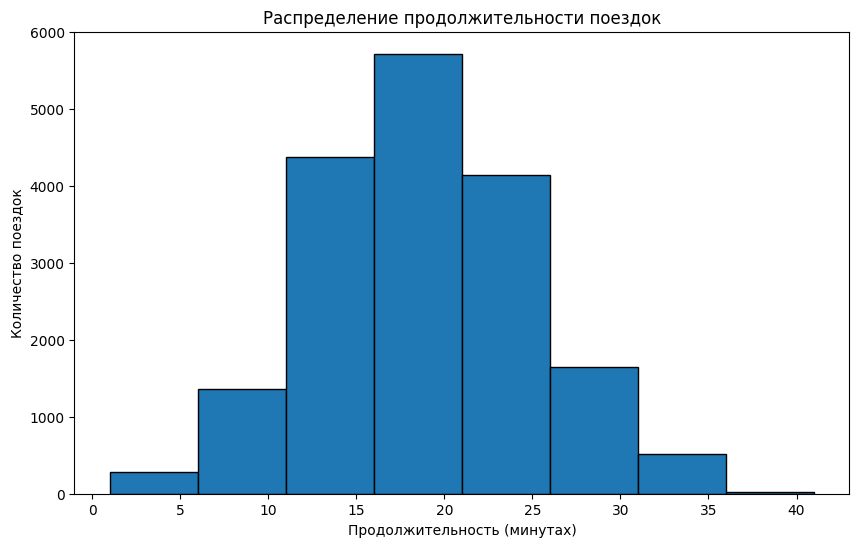

In [39]:
plt.figure(figsize=FIGSIZE)
plt.hist(rides_data['duration'], bins=8, edgecolor='black')
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (минутах)')
plt.ylabel('Количество поездок')
plt.show()

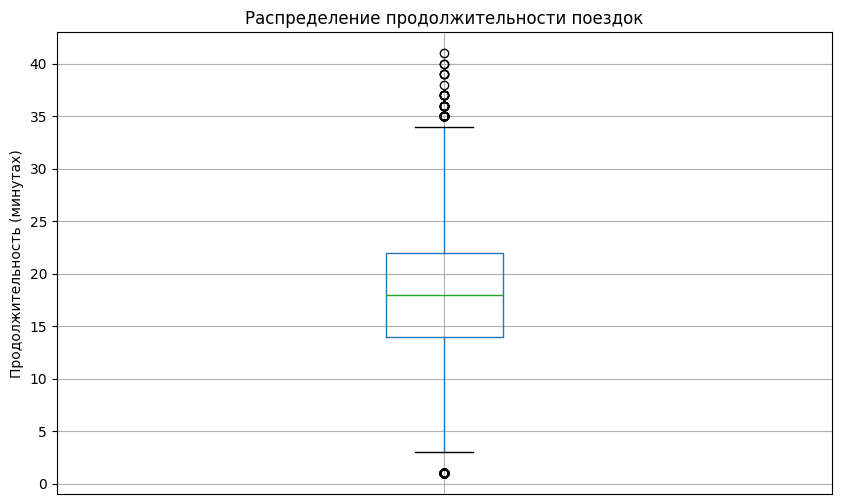

In [40]:
rides_data.boxplot(column='duration', figsize=FIGSIZE)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Распределение продолжительности поездок')
plt.ylabel('Продолжительность (минутах)')
plt.xlabel('')
plt.show()

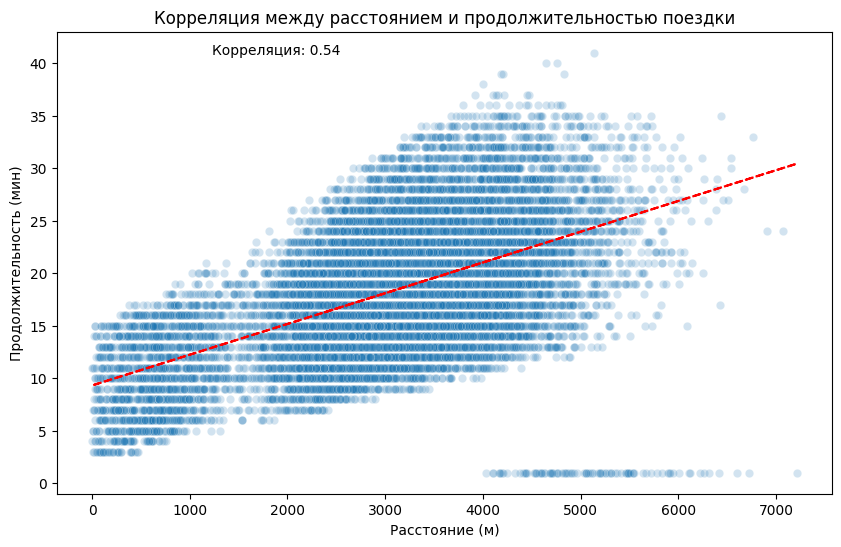

In [41]:
plt.figure(figsize=FIGSIZE)
sns.scatterplot(x='distance', y='duration', data=rides_data, alpha=0.2)
plt.title('Корреляция между расстоянием и продолжительностью поездки')
plt.xlabel('Расстояние (м)')
plt.ylabel('Продолжительность (мин)')

z = np.polyfit(rides_data['distance'], rides_data['duration'], 1)
p = np.poly1d(z)
plt.plot(rides_data['distance'], p(rides_data['distance']), "r--", alpha=1)

correlation = rides_data['distance'].corr(rides_data['duration'])

plt.text(0.2, 0.95, f'Корреляция: {correlation:.2f}', transform=plt.gca().transAxes)

plt.show()

###### Аномалии
В облаке коррелиции заметны аномалии, поездки длительность которых менее 5ти минут а расстояние более 4км!

Скорость при расстоянии S = 4 километра и времени T = 1 минута, равна 240 километров в час.

In [42]:
abnormal_rides = rides_data.loc[(rides_data['duration'] < 5) & (rides_data['distance'] > 4000)]

In [43]:
abnormal_rides

,user_id,distance,duration,date,month,distance_group
6531,701,"4,197.00",1.00,2021-08-31,8,4000-5000
6570,704,"4,831.00",1.00,2021-10-14,10,4000-5000
6680,712,"4,685.00",1.00,2021-03-04,3,4000-5000
6695,713,"5,216.00",1.00,2021-02-25,2,5000+
6768,718,"5,198.00",1.00,2021-02-11,2,5000+
...,...,...,...,...,...,...
17004,1460,"5,532.00",1.00,2021-01-19,1,5000+
17242,1477,"6,725.00",1.00,2021-01-12,1,5000+
17314,1483,"4,446.00",1.00,2021-03-06,3,4000-5000
17505,1496,"5,723.00",1.00,2021-02-14,2,5000+


###### Выводы
* `Распределение`: имеет колоколообразную форму с небольшой правосторонней асимметрией.
* `Пик`: приходиться на 15 - 20 минут
* `Центральная тенденция`: Большинство поездок длится от 10 до 25 минут.
* `Положительная корреляция`: Видна явная положительная связь между расстоянием и продолжительностью поездки. Коэффициент корреляции составляет 0.54, что указывает на умеренную положительную корреляцию.
* `Разброс данных`: Наблюдается значительный разброс точек, особенно с увеличением расстояния. Это говорит о том, что на продолжительность поездки влияют и другие факторы помимо расстояния.
* `Плотность данных`: Наибольшая концентрация поездок наблюдается в диапазоне от 1000 до 5000 метров и продолжительностью от 10 до 25 минут.
* `Неоднородность распределения`: С увеличением расстояния разброс продолжительности поездок увеличивается, что может быть связано с большей вариативностью условий на длинных маршрутах.
* `Кластеризация`: Наблюдается два кластера!
    * `Левый кластер`: Охватывает поездки на короткие расстояния, примерно до 1500 метров. Продолжительность этих поездок варьируется от 0 до примерно 20 минут.
    * `Правый кластер`: Более крупный и рассеянный, охватывает поездки на расстояния от примерно 2000 до 6000+ метров, с продолжительностью до 40 минут.
    * `Разделение кластеров`: Заметен явный "перешеек" или область разрежения данных между двумя кластерами, примерно на отметке 1500-2000 метров.
* `Линия тренда`: Красная пунктирная линия показывает общую тенденцию увеличения продолжительности поездки с увеличением расстояния.
* `Инсайд`: Наличие двух кластеров может указывать на необходимость разных подходов к ценообразованию и обслуживанию для коротких и длинных поездок.
* `Аномалии`: Присутствуют точки с продолжительностью менее 5ти минут на расстояниях, от 4 км, что может говорить о серьёзных ошибках! На данный момент вижу основания для удаления аномальных данных! Однако стоит обратить внимание заказчика на это.

In [44]:
rides_data_len_before_drop = len(rides_data)
rides_data = rides_data.loc[~((rides_data['duration'] < 5) & (rides_data['distance'] > 4000))]
a, b = rides_data_len_before_drop, len(rides_data)
print(a, b, round((a-b)/a*100, 2), '% данных удалено.')

18068 17973 0.53 % данных удалено.


#### Общий вывод по результатам исследовательского анализа данных

**Демографический и географический охват:**

Сервис демонстрирует относительно равномерное распределение пользователей по городам.
Целевая аудитория сконцентрирована в возрастном диапазоне 20-35 лет, с наибольшей плотностью пользователей в возрасте 23-28 лет. Межквартильный размах возраста составляет примерно от 22 до 30 лет.


**Бизнес-модель и пользовательское поведение:**

Платная подписка имеет равномерное распределение по возрастам, с небольшим преобладанием среди пользователей 20-30 лет.
Не выявлено явной линейной зависимости между возрастом и количеством поездок.


**Характеристики поездок:**

Распределение расстояний и продолжительности поездок имеет колоколообразную форму с небольшой правосторонней асимметрией.
Большинство поездок длится от 10 до 25 минут, с пиком в 15-20 минут.
Наблюдается умеренная положительная корреляция (0.54) между расстоянием и продолжительностью поездки.
Выявлено два кластера поездок: короткие (до 1500 м) и длинные (2000-6000+ м), что может потребовать различных подходов к ценообразованию и обслуживанию.


**Технические аспекты и аномалии:**

Обнаружены поездки со скоростью более 240 км/ч, это явно за пределами возможностей самоката и явно указывает на возможные ошибки в данных. Рекомендуется дополнительное расследование причин их появления.


**Юридические аспекты:**

Необходимо учитывать ограничения ПДД для пользователей младше 14 лет, которые могут передвигаться на электросамокатах только в пешеходных зонах и по велосипедной части велодорожек.


**Рекомендации:**

Разработать стратегии для привлечения и удержания пользователей в возрасте 20-35 лет, как наиболее активной группы.
Адаптировать ценовую политику и сервисное обслуживание с учетом выявленных кластеров поездок (короткие и длинные).
Обеспечить соблюдение правил ПДД, особенно в отношении несовершеннолетних пользователей.
Провести дополнительное расследование причин появления поездок с нулевой продолжительностью.

#### Объединение данных

In [45]:
users_data.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [46]:
df = pd.merge(users_data, rides_data, on='user_id', how='right')
df = pd.merge(df, subscriptions_data, on='subscription_type', how='left')

In [47]:
df.columns

Index(['user_id', 'name', 'age', 'city', 'subscription_type', 'distance',
       'duration', 'date', 'month', 'distance_group', 'minute_price',
       'start_ride_price', 'subscription_fee'],
      dtype='object')

In [48]:
df.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,distance_group,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,410.00",26.00,2021-01-01,1,4000-5000,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,618.00",16.00,2021-01-18,1,2000-3000,6,0,199
2,1,Кира,22,Тюмень,ultra,755.00,7.00,2021-04-20,4,0-1000,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,695.00",19.00,2021-08-11,8,2000-3000,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,029.00",27.00,2021-08-28,8,4000-5000,6,0,199
5,1,Кира,22,Тюмень,ultra,"2,771.00",17.00,2021-10-09,10,2000-3000,6,0,199
6,1,Кира,22,Тюмень,ultra,"3,040.00",15.00,2021-10-19,10,3000-4000,6,0,199
7,1,Кира,22,Тюмень,ultra,"2,843.00",24.00,2021-11-06,11,2000-3000,6,0,199
8,1,Кира,22,Тюмень,ultra,"3,413.00",16.00,2021-11-14,11,3000-4000,6,0,199
9,1,Кира,22,Тюмень,ultra,749.00,16.00,2021-11-22,11,0-1000,6,0,199


In [49]:
df_ultra = df.loc[df['subscription_type'] == 'ultra']
df_free = df.loc[df['subscription_type'] == 'free']

In [50]:
if df.shape[0] == (df_free.shape[0] + df_ultra.shape[0]):
    print('OK')

OK


##### Расстояние и время поездок для пользователей без подписки

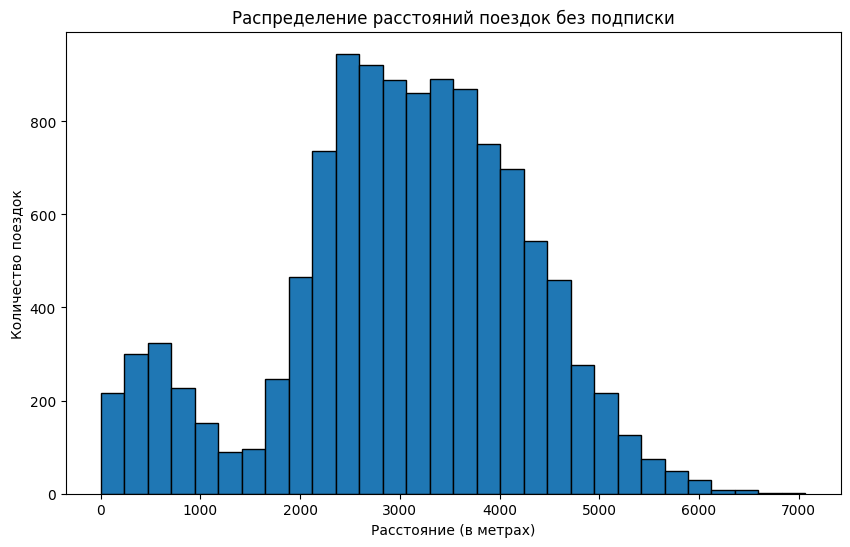

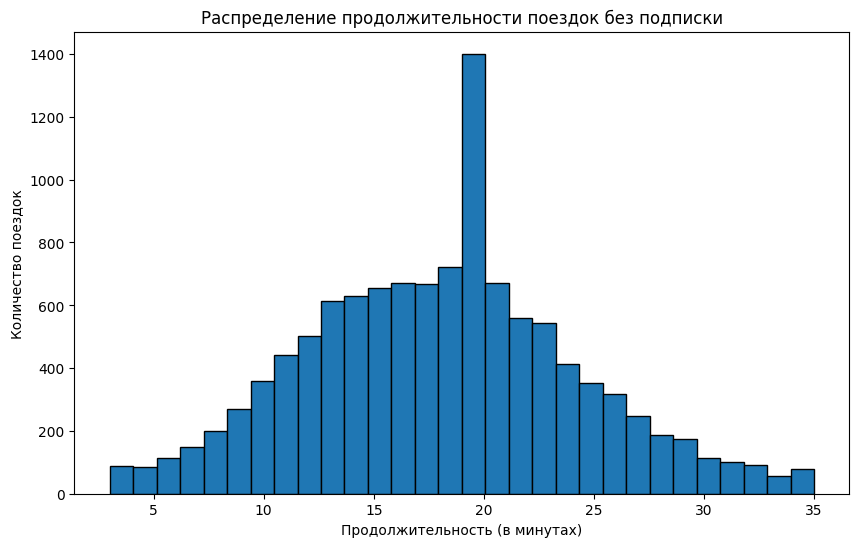

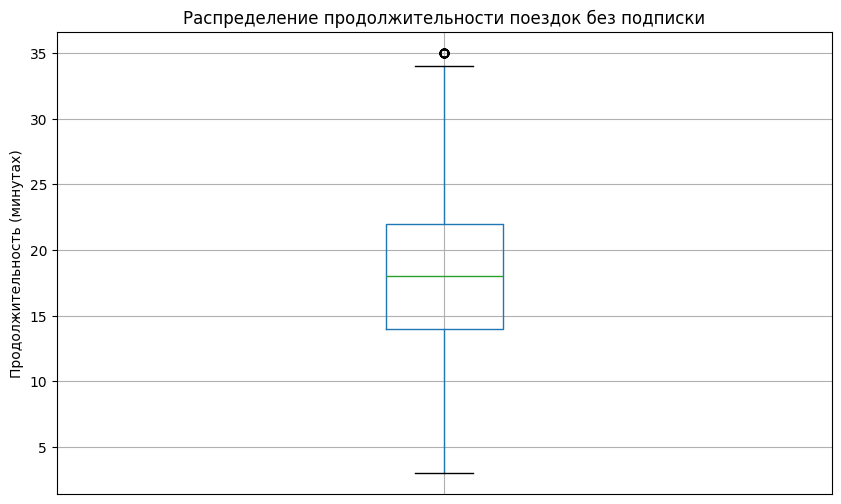

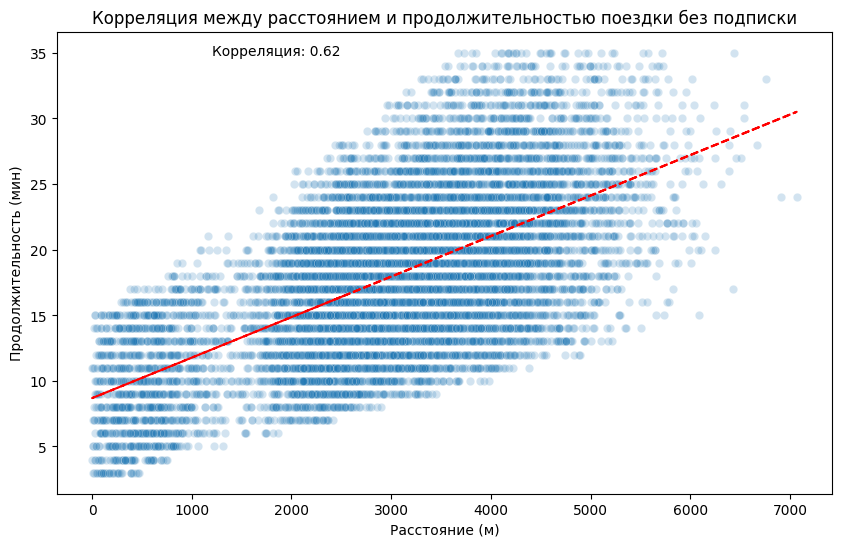

In [51]:
plt.figure(figsize=FIGSIZE)
plt.hist(df_free['distance'], bins=30, edgecolor='black')
plt.title('Распределение расстояний поездок без подписки')
plt.xlabel('Расстояние (в метрах)')
plt.ylabel('Количество поездок')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.hist(df_free['duration'], bins=30, edgecolor='black')
plt.title('Распределение продолжительности поездок без подписки')
plt.xlabel('Продолжительность (в минутах)')
plt.ylabel('Количество поездок')
plt.show()

df_free.boxplot(column='duration', figsize=FIGSIZE)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Распределение продолжительности поездок без подписки')
plt.ylabel('Продолжительность (минутах)')
plt.xlabel('')
plt.show()

plt.figure(figsize=FIGSIZE)
sns.scatterplot(x='distance', y='duration', data=df_free, alpha=0.2)
plt.title('Корреляция между расстоянием и продолжительностью поездки без подписки')
plt.xlabel('Расстояние (м)')
plt.ylabel('Продолжительность (мин)')

z = np.polyfit(df_free['distance'], df_free['duration'], 1)
p = np.poly1d(z)
plt.plot(df_free['distance'], p(df_free['distance']), "r--", alpha=1)
correlation = df_free['distance'].corr(df_free['duration'])
plt.text(0.2, 0.95, f'Корреляция: {correlation:.2f}', transform=plt.gca().transAxes)
plt.show()

In [52]:
df_free['duration'].mode()

0   18.00
Name: duration, dtype: float64

In [53]:
df_free['distance'].mode()

0   3,977.00
Name: distance, dtype: float64

##### Расстояние и время поездок для пользователей с подпиской

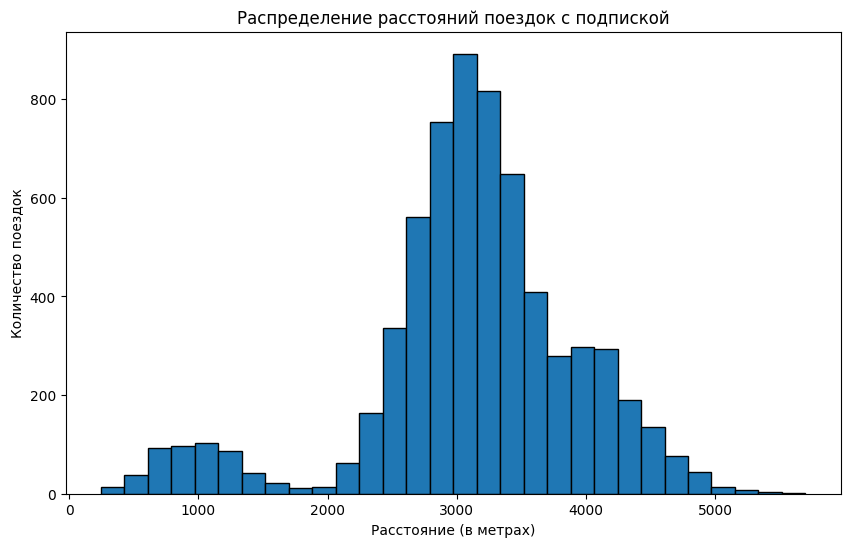

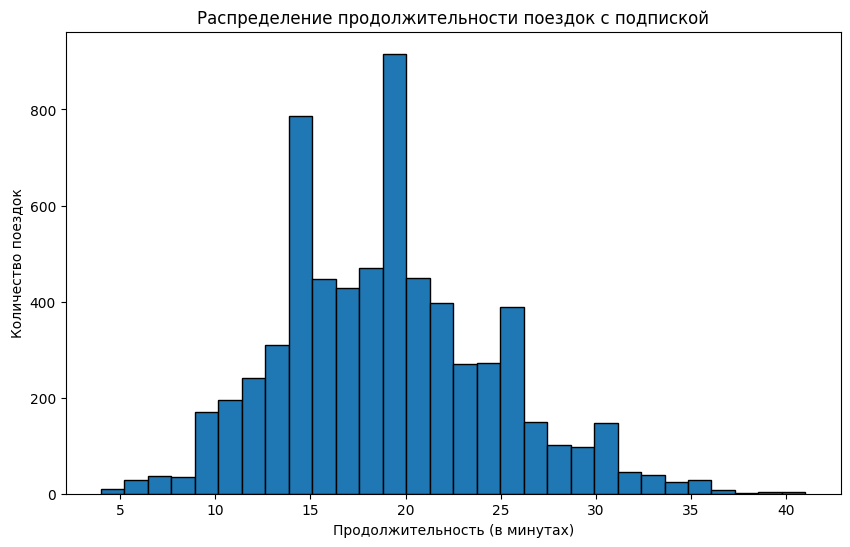

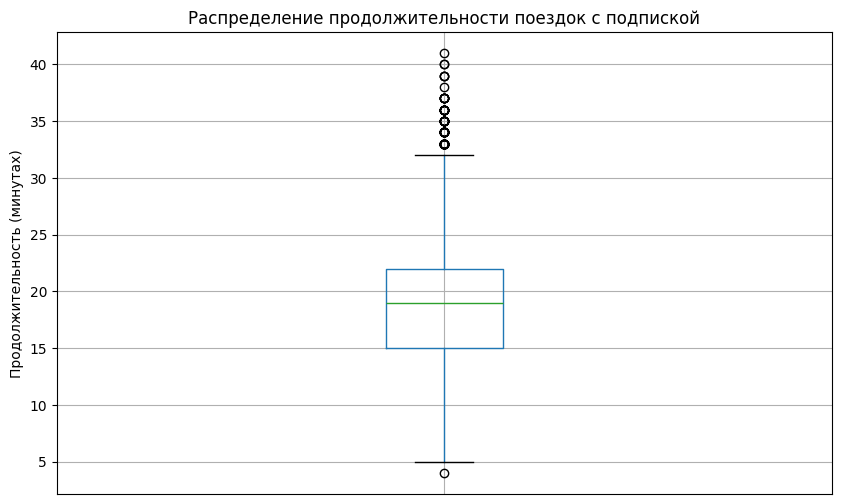

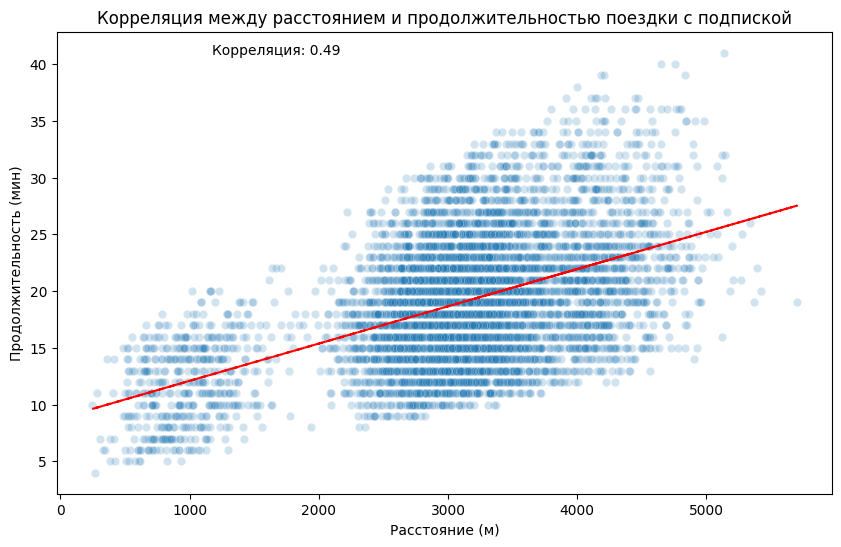

In [54]:
plt.figure(figsize=FIGSIZE)
plt.hist(df_ultra['distance'], bins=30, edgecolor='black')
plt.title('Распределение расстояний поездок с подпиской')
plt.xlabel('Расстояние (в метрах)')
plt.ylabel('Количество поездок')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.hist(df_ultra['duration'], bins=30, edgecolor='black')
plt.title('Распределение продолжительности поездок с подпиской')
plt.xlabel('Продолжительность (в минутах)')
plt.ylabel('Количество поездок')
plt.show()

df_ultra.boxplot(column='duration', figsize=FIGSIZE)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Распределение продолжительности поездок с подпиской')
plt.ylabel('Продолжительность (минутах)')
plt.xlabel('')
plt.show()

plt.figure(figsize=FIGSIZE)
sns.scatterplot(x='distance', y='duration', data=df_ultra, alpha=0.2)
plt.title('Корреляция между расстоянием и продолжительностью поездки с подпиской')
plt.xlabel('Расстояние (м)')
plt.ylabel('Продолжительность (мин)')

z = np.polyfit(df_ultra['distance'], df_ultra['duration'], 1)
p = np.poly1d(z)
plt.plot(df_ultra['distance'], p(df_ultra['distance']), "r--", alpha=1)
correlation = df_ultra['distance'].corr(df_ultra['duration'])
plt.text(0.2, 0.95, f'Корреляция: {correlation:.2f}', transform=plt.gca().transAxes)
plt.show()

In [55]:
df_ultra['duration'].mode()

0   19.00
Name: duration, dtype: float64

In [56]:
df_ultra['distance'].mode()

0   2,923.00
1   2,966.00
2   3,120.00
Name: distance, dtype: float64

##### Вывод по результатам объединения данных и визуализации информации о поездках для пользователей с подпиской и без подписки.

1. Объединили данные о пользователях, поездках и подписках в один общий датафрейм.
2. На основе общего датафрейма, мы создали еще два датафрейма для категоризации пользователей по подписке.

**Расстояния:**

1. Для обеих групп пользователей распределение приблизительно схожее с нормальным, распределения имеет схожую форму с пиком в диапазоне 2500-3500 метров.
2. У пользователей без подписки дополнительный пик в районе 500-1000 метров, что может указывать на более частые короткие поездки.

**Продолжительность:**
1. В обеих группах пик продолжительности поездок около 20 минут.
2. У пользователей с подпиской распределение более равномерное, с заметным дополнительным пиком около 15 минут.
3. Для обеих групп наблюдается положительная корреляция между расстоянием и продолжительностью поездки.
4. Для пользователей без подписки модальное значение продолжительности поездки составляет 17 минут, а расстояния - 3076 метров а для пользователей с подпиской модальное значение продолжительности - 18 минут, а расстояния имеет три значения: 2922, 2965 и 3119 метров, возможно это указывает на то что пользователи с подпиской, совершают более разнообразные по длительности и расстоянию поездки.

#### Подсчёт выручки

In [57]:
df_rides = df.groupby(['user_id', 'month']).agg({
    'duration': 'sum',
    'distance': ['sum', 'count'],
    'subscription_type': 'first',
}).reset_index()

df_rides.columns = ['user_id', 'month', 'duration_sum', 'distance_sum', 'ride_count', 'subscription_type']

df_rides.head(30)

,user_id,month,duration_sum,distance_sum,ride_count,subscription_type
0,1,1,42.00,"7,028.00",2,ultra
1,1,4,7.00,755.00,1,ultra
2,1,8,46.00,"6,724.00",2,ultra
3,1,10,32.00,"5,811.00",2,ultra
4,1,11,56.00,"7,005.00",3,ultra
5,1,12,28.00,"6,753.00",2,ultra
6,2,3,63.00,"10,190.00",3,ultra
7,2,4,40.00,"6,165.00",2,ultra
8,2,6,14.00,"3,256.00",1,ultra
9,2,7,48.00,"6,781.00",2,ultra


In [58]:
def takings(row):
    if row['subscription_type'] == 'ultra':
        return 199 + 6 * row['duration_sum']
    elif row['subscription_type'] == 'free':
        return 50 * row['ride_count'] + 8 * row['duration_sum']
    
df_rides['takings'] = df_rides.apply(takings, axis=1)

df_rides.head(20)

,user_id,month,duration_sum,distance_sum,ride_count,subscription_type,takings
0,1,1,42.00,"7,028.00",2,ultra,451.00
1,1,4,7.00,755.00,1,ultra,241.00
2,1,8,46.00,"6,724.00",2,ultra,475.00
3,1,10,32.00,"5,811.00",2,ultra,391.00
4,1,11,56.00,"7,005.00",3,ultra,535.00
5,1,12,28.00,"6,753.00",2,ultra,367.00
6,2,3,63.00,"10,190.00",3,ultra,577.00
7,2,4,40.00,"6,165.00",2,ultra,439.00
8,2,6,14.00,"3,256.00",1,ultra,283.00
9,2,7,48.00,"6,781.00",2,ultra,487.00


In [59]:
df_rides['takings'].describe()

count   11,300.00
mean       342.75
std        153.32
min         74.00
25%        234.00
50%        319.00
75%        415.00
max      1,444.00
Name: takings, dtype: float64

In [60]:
df_rides.query('subscription_type == "ultra"')['takings'].describe()


count   4,533.00
mean      362.79
std        88.26
min       223.00
25%       301.00
50%       337.00
75%       409.00
max       955.00
Name: takings, dtype: float64

In [61]:
df_rides.query('subscription_type == "free"')['takings'].describe()

count   6,767.00
mean      329.33
std       183.27
min        74.00
25%       194.00
50%       274.00
75%       428.00
max     1,444.00
Name: takings, dtype: float64

##### Вывод
* **Пользователи с подпиской:**
    * Минимальная выручка - 223 р.
    * Средняя выручка - 337 р.
    * Максимальная - 955 р.
* **Пользователи без подписки:**
    * Минимальная выручка - 58 р.
    * Средняя выручка - 274 р.
    * Максимальная - 1444 р.

Можно сделать вывод о том что пользователи с подпиской в среднем тратят больше.

#### Проверка гипотез

##### Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки

**H0:** Длительность с подпиской = длительность без подписки

**H1:** Длительность с подпиской > длительность без подписки

In [62]:
ultra = df_ultra['duration']
free = df_free['duration']

alpha = 0.05

res = st.ttest_ind(ultra, free, alternative='greater')

print('pvalue =', res.pvalue)

if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отверагем нулевую гипотезу')

pvalue = 8.577910347796266e-28
Отвергаем нулевую гипотезу


##### Гипотеза 2. Пользователи с подпиской за одну поездку проезжают более 3130 метров

**H0:** Дистанция = 3130

**H1:** Дистанция < 3130

In [63]:
distance = df_ultra['distance']
interested_distance = 3130

alpha = 0.05

res = st.ttest_1samp(distance, interested_distance, alternative='greater')

print('pvalue =', res.pvalue)

if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

pvalue = 0.9120422337080507
Не отвергаем нулевую гипотезу


##### Гипотеза 3. Помесячная выручка от пользователей с подпиской больше чем выручка от пользователей без подписки

**H0:** Выручка с подпиской = выручка без подписки

**H1:** Выручка с подпиской > выручка без подписки

In [64]:
takings_ultra = df_rides.query('subscription_type == "ultra"')['takings']
takings_free = df_rides.query('subscription_type == "free"')['takings']

alpha = 0.05

res = st.ttest_ind(takings_ultra, takings_free, alternative='greater')

print('pvalue =', res.pvalue)

if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

pvalue = 2.0314113674863288e-30
Отвергаем нулевую гипотезу


##### Вопрос о том как проверить гипотезу о снижении колличества обращений в поддержку после обновления приложения?

**H0:** Количество обращений до == количество обращений после

**H1:** Количество обращений до обновления > количество обращений после

Предположим что у нас есть dataframe, назовём его `support_data` c калонками `before` и `after`

```
t_statistic, p_value = stats.ttest_rel(support_data['before'], 
                                       support_data['after'],
                                       alternative='greater')

alpha = 0.05

if p_value < alpha and t_statistic > 0:
    print('Отвергаем нулевую гипотезу. Есть статистически значимое снижение количества обращений.')
else:
    print('Нет достаточных оснований отвергнуть нулевую гипотезу.')
```

##### Заключение

**На основании проведенного исследования и анализа данных сервиса аренды самокатов можно сделать следующие выводы:**

* Исследование выявило ключевые особенности пользовательской базы и паттернов использования сервиса. Средний возраст пользователей составляет 24-25 лет, что указывает на молодую целевую аудиторию. Распределение между пользователями с бесплатной и платной подпиской примерно равное, с небольшим преобладанием бесплатных аккаунтов (54% против 46%).

* Анализ поездок показал, что средняя дистанция составляет около 3070 метров, а средняя продолжительность - 17 минут. Важно отметить наличие очень коротких поездок, что может указывать на технические ошибки и требует дополнительного расследования.

* Статистический анализ подтвердил, что пользователи с подпиской проводят значительно больше времени в поездках по сравнению с пользователями без подписки. Это может свидетельствовать о том, что подписка стимулирует более активное использование сервиса.

* Интересно, что гипотеза о том, что пользователи с подпиской проезжают в среднем более 3130 метров за поездку, не подтвердилась. Это говорит о том, что длина поездки не зависит от наличия подписки, и обе группы пользователей демонстрируют схожие паттерны в отношении дистанции.

* Ключевым выводом является то, что помесячная выручка от пользователей с подпиской значительно превышает выручку от пользователей без подписки. Это подчеркивает ценность подписчиков для.

**Основываясь на этих данных, рекомендуется:**

1. Разработать стратегии по увеличению числа пользователей с подпиской, так как они приносят больше выручки и активнее пользуются сервисом.
2. Исследовать причины коротких поездок и оптимизировать систему для минимизации случайных активаций.
3. Рассмотреть возможность создания таргетированных маркетинговых кампаний, ориентированных на молодую аудиторию (20-30 лет).
4. Проанализировать факторы, влияющие на длительность поездок, и использовать эти данные для улучшения пользовательского опыта.
5. Провести дополнительное исследование для понимания, почему пользователи с подпиской проводят больше времени в поездках, но не проезжают большие расстояния.